In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sparse
import scipy as sp

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


## Step 1: Initialize data

In [9]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'neurips' / 'neurips_train.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type'],
                    'conditioning_covariate': 'cell_type',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 256}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Step 2: Initialize encoder

In [10]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 50],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_train_autoencoder_neurips_whole_genome/eabc6534-947b-4486-8012-c9e351b297ca/checkpoints/epoch_59.ckpt"

In [11]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

encoder_model.eval()

EncoderModel(
  (x0_from_x): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=14087, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=256, out_features=50, bias=True)
    )
  )
  (x_from_x0): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=50, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_runnin

## Initialize FM model

In [12]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001
                        }

In [13]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_fm_resnet_autoencoder_neurips_whole_genome/8117877a-f196-4142-a528-2ecdd6294151/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [14]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 0.0335, -0.1560, -0.5291,  ...,  0.3735, -0.0941, -0.8921],
        [-0.7772,  0.1002,  0.2768,  ..., -0.9797,  0.9892, -0.2922],
        [-0.1416, -0.6285, -1.9562,  ..., -0.4058,  1.5861, -1.3475],
        ...,
        [ 1.1412, -1.0427, -0.4340,  ...,  0.5399, -1.1693,  0.6423],
        [-0.2317, -0.1948,  0.5764,  ...,  1.3119, -2.3207,  0.7109],
        [-1.7751,  1.2498,  1.1430,  ..., -1.6456,  0.3279,  0.6074]],
       device='cuda:0', requires_grad=True)


Initializations

In [15]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=14087, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
         

**Check the data**

In [16]:
adata_original = sc.read_h5ad(DATA_DIR / 'processed_full_genome' / 'neurips' / 'neurips_train.h5ad')
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [17]:
adata_original

AnnData object with n_obs × n_vars = 72208 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'size_factor'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'dataset_id', 'genome', 'log1p', 'neighbors', 'organism', 'pca', 'umap'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'connectivities', 'distances'

In [18]:
unique_classes = np.unique(adata_original.obs.cell_type, return_counts=True)
class_freq_dict = dict(zip(unique_classes[0], unique_classes[1]))
norm_const = np.sum(1/unique_classes[1])
class_prop_dict = dict(zip(unique_classes[0], (1/unique_classes[1])/norm_const))
class_prop = (1/unique_classes[1])/norm_const
class_idx = dict(zip(range(len(unique_classes[0])), unique_classes[0]))

In [20]:
class_freq_dict

{'B1 B IGKC+': 653,
 'B1 B IGKC-': 493,
 'CD14+ Mono': 17333,
 'CD16+ Mono': 2083,
 'CD4+ T CD314+ CD45RA+': 72,
 'CD4+ T activated': 5557,
 'CD4+ T activated integrinB7+': 856,
 'CD4+ T naive': 4712,
 'CD8+ T CD49f+': 758,
 'CD8+ T CD57+ CD45RA+': 1027,
 'CD8+ T CD57+ CD45RO+': 1176,
 'CD8+ T CD69+ CD45RA+': 601,
 'CD8+ T CD69+ CD45RO+': 716,
 'CD8+ T TIGIT+ CD45RA+': 825,
 'CD8+ T TIGIT+ CD45RO+': 934,
 'CD8+ T naive': 2487,
 'CD8+ T naive CD127+ CD26- CD101-': 37,
 'Erythroblast': 3234,
 'G/M prog': 1483,
 'HSC': 1366,
 'ILC': 191,
 'ILC1': 440,
 'Lymph prog': 1320,
 'MAIT': 608,
 'MK/E prog': 567,
 'NK': 4331,
 'NK CD158e1+': 1737,
 'Naive CD20+ B IGKC+': 3204,
 'Naive CD20+ B IGKC-': 1571,
 'Normoblast': 1138,
 'Plasma cell IGKC+': 236,
 'Plasma cell IGKC-': 196,
 'Plasmablast IGKC+': 182,
 'Plasmablast IGKC-': 111,
 'Proerythroblast': 1220,
 'Reticulocyte': 3437,
 'T prog cycling': 23,
 'T reg': 497,
 'Transitional B': 1275,
 'cDC1': 17,
 'cDC2': 1358,
 'dnT': 50,
 'gdT CD158b+':

In [21]:
class_prop_dict

{'B1 B IGKC+': 0.00661345311580795,
 'B1 B IGKC-': 0.008759807068199982,
 'CD14+ Mono': 0.0002491539193805222,
 'CD16+ Mono': 0.002073252465013246,
 'CD4+ T CD314+ CD45RA+': 0.05998034561975821,
 'CD4+ T activated': 0.0007771432219943479,
 'CD4+ T activated integrinB7+': 0.005045075799792746,
 'CD4+ T naive': 0.0009165078278061526,
 'CD8+ T CD49f+': 0.005697341536441413,
 'CD8+ T CD57+ CD45RA+': 0.004205048573147606,
 'CD8+ T CD57+ CD45RO+': 0.0036722660583525437,
 'CD8+ T CD69+ CD45RA+': 0.007185665365428605,
 'CD8+ T CD69+ CD45RO+': 0.006031543134947754,
 'CD8+ T TIGIT+ CD45RA+': 0.00523464834499708,
 'CD8+ T TIGIT+ CD45RO+': 0.004623752553129113,
 'CD8+ T naive': 0.0017364635643838324,
 'CD8+ T naive CD127+ CD26- CD101-': 0.11671851039520517,
 'Erythroblast': 0.0013353694757645615,
 'G/M prog': 0.0029120599356861707,
 'HSC': 0.003161482345990184,
 'ILC': 0.022610392066086865,
 'ILC1': 0.009814965646869525,
 'Lymph prog': 0.003271655215623175,
 'MAIT': 0.0071029356654976825,
 'MK/E p

## General conditional

In [27]:
n_to_sample = 128000

In [28]:
n_to_sample

128000

In [32]:
np.random.seed(42)
samples = np.random.choice(range(len(class_idx)), size=n_to_sample, replace=True, p=sp.special.softmax(class_prop))

In [33]:
condition_names = [class_idx[sample] for sample in samples]
condition_val = torch.tensor([dataset.id2cov["cell_type"][condition_name] for condition_name in condition_names]).long()

X_generated = generative_model.batched_sample(batch_size=128,
                                            repetitions=1000,
                                            n_sample_steps=2, 
                                            covariate="cell_type", 
                                            covariate_indices=condition_val, 
                                            log_size_factor=None)

# X_generated_list= X_generated.to("cpu")

**Create adata and check plots**

In [34]:
adata_generated = sc.AnnData(X=sparse.csr_matrix(deepcopy(X_generated).cpu().numpy()))

In [36]:
generated_classes = np.unique(condition_names, return_counts=True)
generated_classes_dict = dict(zip(generated_classes[0], generated_classes[1]))

In [37]:
generated_classes_dict

{'B1 B IGKC+': 2809,
 'B1 B IGKC-': 2789,
 'CD14+ Mono': 2833,
 'CD16+ Mono': 2801,
 'CD4+ T CD314+ CD45RA+': 2986,
 'CD4+ T activated': 2733,
 'CD4+ T activated integrinB7+': 2785,
 'CD4+ T naive': 2858,
 'CD8+ T CD49f+': 2798,
 'CD8+ T CD57+ CD45RA+': 2797,
 'CD8+ T CD57+ CD45RO+': 2781,
 'CD8+ T CD69+ CD45RA+': 2823,
 'CD8+ T CD69+ CD45RO+': 2693,
 'CD8+ T TIGIT+ CD45RA+': 2770,
 'CD8+ T TIGIT+ CD45RO+': 2872,
 'CD8+ T naive': 2860,
 'CD8+ T naive CD127+ CD26- CD101-': 3084,
 'Erythroblast': 2644,
 'G/M prog': 2772,
 'HSC': 2824,
 'ILC': 2837,
 'ILC1': 2800,
 'Lymph prog': 2770,
 'MAIT': 2848,
 'MK/E prog': 2829,
 'NK': 2792,
 'NK CD158e1+': 2761,
 'Naive CD20+ B IGKC+': 2804,
 'Naive CD20+ B IGKC-': 2782,
 'Normoblast': 2810,
 'Plasma cell IGKC+': 2865,
 'Plasma cell IGKC-': 2843,
 'Plasmablast IGKC+': 2869,
 'Plasmablast IGKC-': 2824,
 'Proerythroblast': 2754,
 'Reticulocyte': 2820,
 'T prog cycling': 3339,
 'T reg': 2830,
 'Transitional B': 2786,
 'cDC1': 3676,
 'cDC2': 2801,
 'd

In [38]:
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

In [39]:
adata_generated.obs["size_factor"] = adata_generated.X.sum(1)

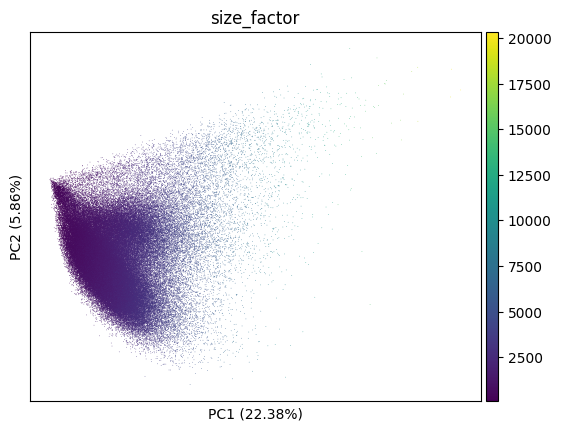

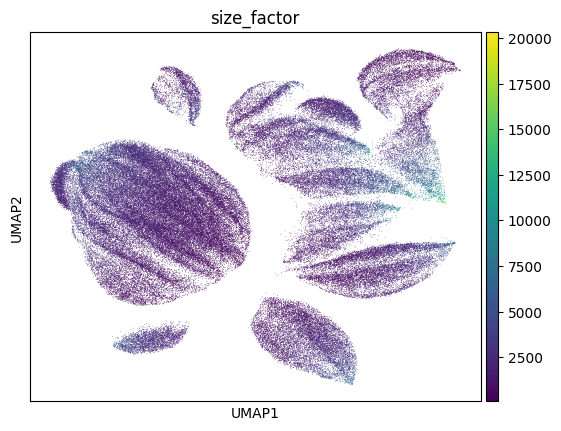

In [40]:
sc.pl.pca(adata_generated, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata_generated, color="size_factor")

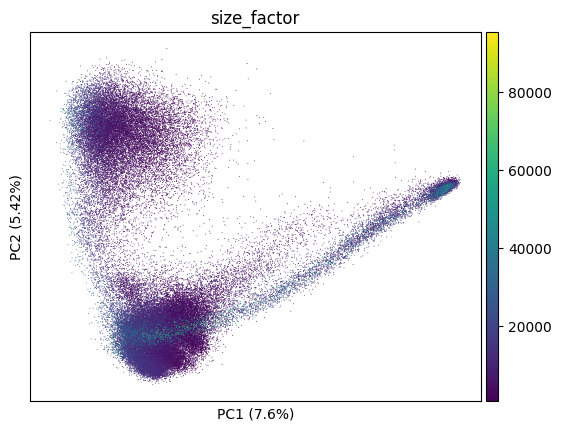

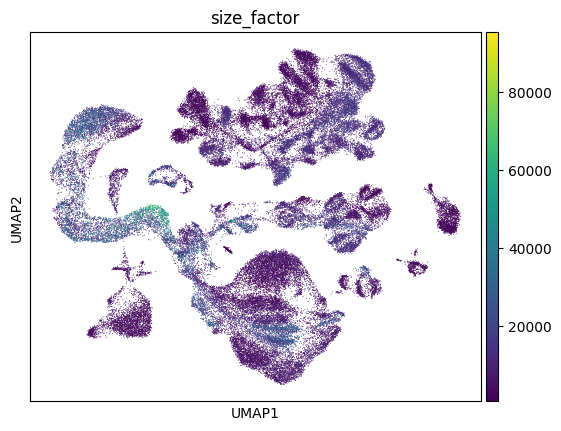

In [41]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

Merge and plot the generated and real data

In [43]:
dataset_type = ["Real" for _ in range(adata_original.X.A.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["cell_type"] = list(adata_original.obs.cell_type)+condition_names[:450000]

In [49]:
adata_merged = sc.AnnData(X=torch.cat([torch.tensor(adata_original.X.A), X_generated], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [50]:
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


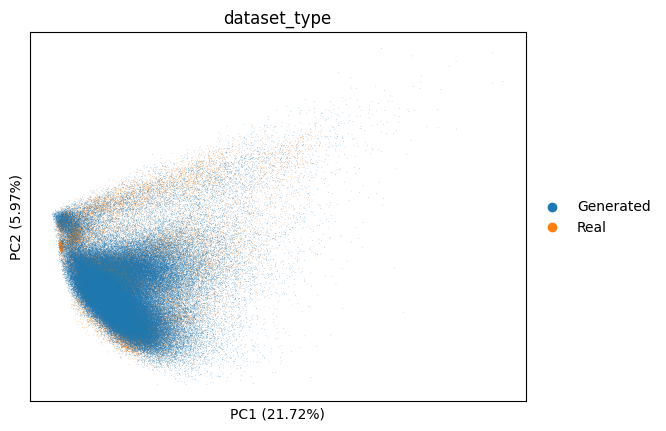

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

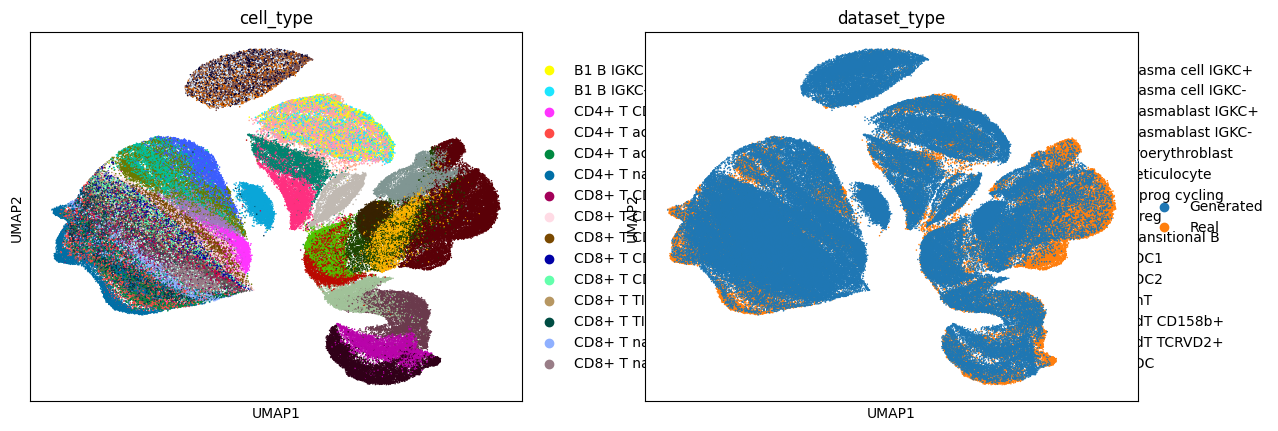

In [51]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color=["cell_type","dataset_type"], s=5)
# sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color=["classes"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


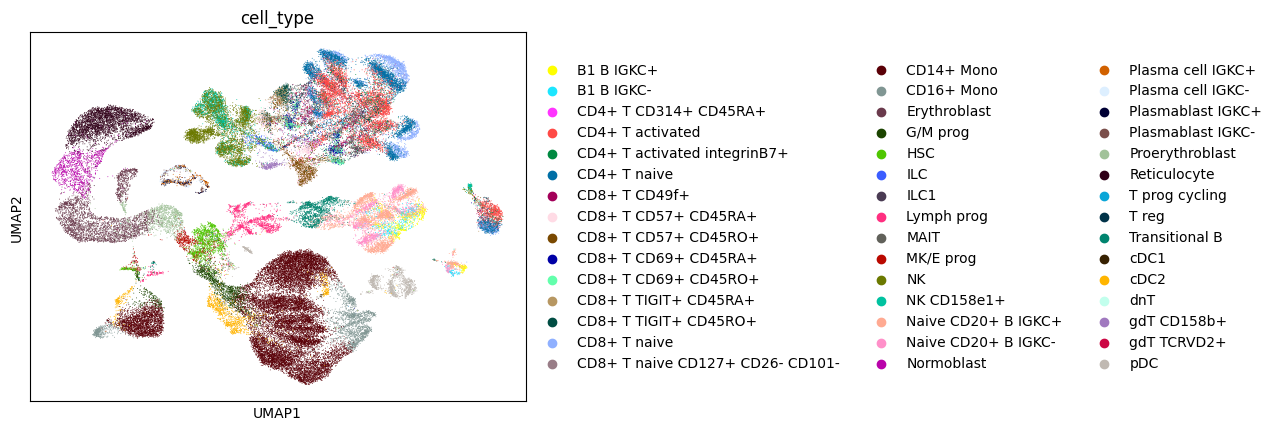

In [56]:
sc.pl.umap(adata_original, color="cell_type")

In [52]:
unique_cell_types_augmented = np.unique(adata_merged.obs.cell_type, return_counts=True)

In [53]:
dict(zip(unique_cell_types_augmented[0], unique_cell_types_augmented[1]))

{'B1 B IGKC+': 3462,
 'B1 B IGKC-': 3282,
 'CD14+ Mono': 20166,
 'CD16+ Mono': 4884,
 'CD4+ T CD314+ CD45RA+': 3058,
 'CD4+ T activated': 8290,
 'CD4+ T activated integrinB7+': 3641,
 'CD4+ T naive': 7570,
 'CD8+ T CD49f+': 3556,
 'CD8+ T CD57+ CD45RA+': 3824,
 'CD8+ T CD57+ CD45RO+': 3957,
 'CD8+ T CD69+ CD45RA+': 3424,
 'CD8+ T CD69+ CD45RO+': 3409,
 'CD8+ T TIGIT+ CD45RA+': 3595,
 'CD8+ T TIGIT+ CD45RO+': 3806,
 'CD8+ T naive': 5347,
 'CD8+ T naive CD127+ CD26- CD101-': 3121,
 'Erythroblast': 5878,
 'G/M prog': 4255,
 'HSC': 4190,
 'ILC': 3028,
 'ILC1': 3240,
 'Lymph prog': 4090,
 'MAIT': 3456,
 'MK/E prog': 3396,
 'NK': 7123,
 'NK CD158e1+': 4498,
 'Naive CD20+ B IGKC+': 6008,
 'Naive CD20+ B IGKC-': 4353,
 'Normoblast': 3948,
 'Plasma cell IGKC+': 3101,
 'Plasma cell IGKC-': 3039,
 'Plasmablast IGKC+': 3051,
 'Plasmablast IGKC-': 2935,
 'Proerythroblast': 3974,
 'Reticulocyte': 6257,
 'T prog cycling': 3362,
 'T reg': 3327,
 'Transitional B': 4061,
 'cDC1': 3693,
 'cDC2': 4159,
 '

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


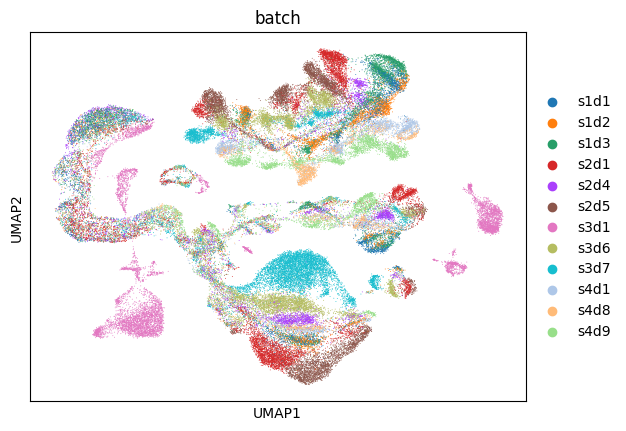

In [63]:
sc.pl.umap(adata_original, color="batch")

In [64]:
# sc.write("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/integration/neurips/augmented_neurips_train.h5ad", adata_merged)